In [1]:
import genesis as gs
import numpy as np
import torch
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)

import spatialmath as sm
from pandaSim.geometry.genesis_adapter import GenesisAdapter
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner

In [2]:
gs.init(backend=gs.cpu, seed=42)

[Genesis] [18:26:00] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [18:26:00] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [18:26:00] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [18:26:02] [INFO] Running on [13th Gen Intel(R) Core(TM) i7-13800H] with backend gs.cpu. Device memory: 31.59 GB.
[Genesis] [18:26:02] [INFO] 🚀 Genesis initialized. 🔖 version: 0.2.1, 🌱 seed: 42, 📏 precision: '32', 🐛 debug: False, 🎨 theme: 'dark'.


In [3]:
adapter = GenesisAdapter()
scene = adapter.scene

[Genesis] [18:26:04] [INFO] Scene <9a3ef60> created.


In [4]:
plane = scene.add_entity(
    gs.morphs.Plane(),
)
franka = scene.add_entity(
    gs.morphs.MJCF(file='xml/franka_emika_panda/panda.xml'),
)

bottle = scene.add_entity(
    material=gs.materials.Rigid(rho=300),
    morph=gs.morphs.URDF(
        file="urdf/3763/mobility_vhacd.urdf",
        scale=0.09,
        pos=(0.65, 0.0, 0.036),
        quat=(-np.pi/2, 0, np.pi/2, 0),
    ),
    # visualize_contact=True,
)

cube_size = (0.07, 0.1, 0.1)
cube_pos = (0.4, 0.4, 0.05)

cube = scene.add_entity(
    gs.morphs.Box(
        size = cube_size,
        pos  = cube_pos,
    ),
    surface=gs.surfaces.Default(
        color = (0.8, 0.1 , 0.1),   
    )
)
cube.surface.color = (0.8, 0.1 , 0.1)

cylinder_pos = (0.7, -0.2, 0.03)
cylinder_quat = (0, -np.sqrt(2)/2, 0, np.sqrt(2)/2)
cylinder_radius = 0.03
cylinder_height = 0.15

cylinder = scene.add_entity(
    gs.morphs.Cylinder(
        radius = cylinder_radius,
        height = cylinder_height,
        pos    = cylinder_pos,
        quat   = cylinder_quat,
    ),
    surface=gs.surfaces.Default(
        color = (0.1, 0.8 , 0.1),   
    )
)
cylinder.surface.color = (0.2, 0.8, 0.2)

cam = scene.add_camera(
    res    = (640, 480),
    pos    = (3.5, 0.0, 2.5),
    lookat = (0, 0, 0.5),
    fov    = 30,
    GUI    = False,
)


[Genesis] [18:31:01] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <df8724d>, morph: <gs.morphs.Plane>, material: <gs.materials.Rigid>.
[Genesis] [18:31:01] [INFO] Adding <gs.RigidEntity>. idx: 1, uid: <17d1ae2>, morph: <gs.morphs.MJCF(file='d:\envs\pygen\Lib\site-packages\genesis\assets\xml/franka_emika_panda/panda.xml')>, material: <gs.materials.Rigid>.
[Genesis] [18:31:02] [WARNING] (MJCF) Tendon not supported
[Genesis] [18:31:02] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint1`
[Genesis] [18:31:02] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [18:31:02] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint2`
[Genesis] [18:31:02] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [18:31:03] [INFO] Adding <gs.RigidEntity>.

In [5]:
scene.build()

[Genesis] [18:31:05] [INFO] Building scene <9a3ef60>...
[Genesis] [18:31:08] [WARNING] Reference robot position exceeds joint limits.
[Genesis] [18:31:08] [WARNING] Constraint solver time constant was increased to avoid numerical instability (from `0.005` to `0.02`). Decrease simulation timestep to avoid altering the original value.
[Genesis] [18:31:29] [INFO] Compiling simulation kernels...
[Genesis] [18:36:43] [INFO] Building visualizer...
[Genesis] [18:36:48] [INFO] Viewer created. Resolution: 1280×960, max_FPS: 60.


In [6]:
motors_dof = np.arange(7)
fingers_dof = np.arange(7, 9)
# set control gains
# Note: the following values are tuned for achieving best behavior with Franka
# Typically, each new robot would have a different set of parameters.
# Sometimes high-quality URDF or XML file would also provide this and will be parsed.
franka.set_dofs_kp(
    np.array([4500, 4500, 3500, 3500, 2000, 2000, 2000, 100, 100]),
)
franka.set_dofs_kv(
    np.array([450, 450, 350, 350, 200, 200, 200, 10, 10]),
)
franka.set_dofs_force_range(
    np.array([-87, -87, -87, -87, -12, -12, -12, -100, -100]),
    np.array([ 87,  87,  87,  87,  12,  12,  12,  100,  100]),
)

# render rgb, depth, segmentation, and normal
# rgb, depth, segmentation, normal = cam.render(rgb=True, depth=True, segmentation=True, normal=True)

In [94]:
# get bottle properties
bottle_pos = bottle.get_pos()
print(f"bottle_pos: {bottle_pos}")
bottle_rot = bottle.get_quat()
print(f"bottle_rot: {bottle_rot}")
bottle_mass = bottle.get_mass()
print(f"bottle_mass: {bottle_mass}")

planner = ScrewMotionPlanner()
bottle_bbox = adapter.get_bbox(bottle)
planner.find_ground_edges(bottle_bbox)
bottle_qs, bottle_s_axes = planner.screw_from_bbox(bottle_bbox)
print(f"bottle screw params qs: {bottle_qs}")
print(f"bottle screw params s_axes: {bottle_s_axes}")
# bottle_vertices = bottle.get_verts()
# print(f"bottle_vertices: {bottle_vertices}")
bottle_bbox = bottle.get_AABB()
bottle.size = bottle_bbox[1] - bottle_bbox[0]

# get cubes prperties
cube_pos = cube.get_pos()
print(f"cube_pos: {cube_pos}")
cube_rot = cube.get_quat()
print(f"cube_rot: {cube_rot}")
cube_mass = cube.get_mass()
print(f"cube_mass: {cube_mass}")
cube_vertices = cube.get_verts()
print(f"cube_vertices: {cube_vertices}")

cube.size = cube_size

# get cylinder properties
cylinder_pos = cylinder.get_pos()
print(f"cylinder_pos: {cylinder_pos}")
cylinder_rot = cylinder.get_quat()
print(f"cylinder_rot: {cylinder_rot}")
cylinder_mass = cylinder.get_mass()
print(f"cylinder_mass: {cylinder_mass}")
# cylinder_vertices = cylinder.get_verts()
# print(f"cylinder_vertices: {cylinder_vertices}")
cylinder.size = (cylinder_height, cylinder_radius)

bottle_pos: tensor([0.6500, 0.0000, 0.0360])
bottle_rot: tensor([-0.7071,  0.0000,  0.7071,  0.0000])
bottle_mass: 0.09222162768927847
bottle screw params qs: [[5.6069762e-01 4.7992636e-04 2.1613464e-03]
 [7.2746480e-01 4.7992636e-04 2.1613464e-03]]
bottle screw params s_axes: [[0. 1. 0.]
 [0. 1. 0.]]
cube_pos: tensor([0.4000, 0.4000, 0.0500])
cube_rot: tensor([1., 0., 0., 0.])
cube_mass: 0.14000000000000004
cube_vertices: tensor([[0.3650, 0.3500, 0.0000],
        [0.3650, 0.3500, 0.1000],
        [0.3650, 0.4500, 0.0000],
        [0.3650, 0.4500, 0.1000],
        [0.4350, 0.3500, 0.0000],
        [0.4350, 0.3500, 0.1000],
        [0.4350, 0.4500, 0.0000],
        [0.4350, 0.4500, 0.1000]])
cylinder_pos: tensor([ 0.7000, -0.2000,  0.0300])
cylinder_rot: tensor([ 0.0000, -0.7071,  0.0000,  0.7071])
cylinder_mass: 0.0842790191109674


In [262]:
def get_obj_screw(object):
    """
    Get the screw parameters of the object
    """
    if object == bottle:
        planner = ScrewMotionPlanner()
        bottle_bbox = adapter.get_bbox(bottle)
        planner.find_ground_edges(bottle_bbox)
        bottle_qs, bottle_s_axes = planner.screw_from_bbox(bottle_bbox)
        s1, s2 = bottle_s_axes
        q1, q2 = bottle_qs
        h1 = 0
        h2 = 0
    else:
        # get the vertices of the object
        vertices = object.get_verts()
        vertices = vertices.numpy()

        # get the max and min x, y, z coordinates
        max_x = np.max(vertices[:, 0])
        min_x = np.min(vertices[:, 0])
        min_y = np.min(vertices[:, 1])
        min_z = np.min(vertices[:, 2])
        max_y = np.max(vertices[:, 1])
        
        v1 = np.array([max_x, min_y, min_z])  # max x, min y, min z
        v2 = np.array([max_x, max_y, min_z])  # max x, max y, min z
        v3 = np.array([min_x, max_y, min_z])  # min x, max y, min z
        v4 = np.array([min_x, min_y, min_z])  # min x, min y, min z
        
        if np.linalg.norm(v1-v2) <= np.linalg.norm(v2-v3):
            s1 = (v1-v2) / np.linalg.norm(v1-v2) # unit vector in the direction of the screw axis
            q1 = v2 # point on the screw axis
            h1 = 0 # pitch of the screw axis
            s2 = (v4-v3) / np.linalg.norm(v4-v3) # unit vector in the direction of the screw axis
            q2 = v4 # point on the screw axis
            h2 = 0 # pitch of the screw axis
        else:
            s1 = (v2-v3) / np.linalg.norm(v2-v3) # unit vector in the direction of the screw axis
            q1 = v2 # point on the screw axis
            h1 = 0 # pitch of the screw axis
            s2 = (v1-v4) / np.linalg.norm(v1-v4) # unit vector in the direction of the screw axis
            q2 = v1 # point on the screw axis
            h2 = 0 # pitch of the screw axis
    
    #pt.check_screw_parameters(q, s, h) # check if the screw parameters are valid
    return s1, q1, h1, s2, q2, h2


def obj_dq(object, method):
    """
    Get the screw parameters of the object and apply sclerp to the object in dual quaternion
    """
    if method == 'min_distance':
        _,_,_,s,q,h = get_obj_screw(object)
        theta = np.pi/2
    elif method == 'max_distance':
        s,q,h,_,_,_ = get_obj_screw(object)
        theta = -np.pi/2

    
    pq = object.get_qpos().cpu().numpy()
    pq = pq[0:7] # position and quaternion of the object
    obj_initial_dq = pt.dual_quaternion_from_pq(pq) # dual quaternion from position and quaternion
    
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=h, theta=theta) # dual quaternion from screw parameters that make the object upright
    # intermediate_T = pt.transform_log_from_screw_matrix
    # Screw_T = pt.transform_from_dual_quaternion(Screw_dq) # transform from dual quaternion to transformation matrix
    # print("screw_dq: \n", Screw_dq)
    # print("screw_T: \n", Screw_T)
    obj_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, obj_initial_dq)
    #obj_goal_T = pt.transform_from_dual_quaternion(obj_goal_dq) # transform from dual quaternion to transformation matrix
    # print("obj_goal_dq: \n", obj_goal_dq)
    # print("obj_goal_T: \n", obj_goal_T)
    return obj_initial_dq, obj_goal_dq


def obj_sclerp(object, obj_initial_dq, obj_goal_dq, method, steps):
    """
    Apply sclerp to the object in dual quaternion
    """
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    dq_traj = [pt.dual_quaternion_sclerp(obj_initial_dq, obj_goal_dq, t) for t in tau]
         # spherical linear interpolation between two dual quaternions
    # get the position and quaternion from the dual quaternion
    dq_traj = np.asarray(dq_traj)
    obj_qpos = ptr.pqs_from_dual_quaternions(dq_traj)
    
    return dq_traj, obj_qpos

def obj_grasp_offset(object, object_initial_dq, method):
    
    m = 1
    if method == 'min_distance':
        m = -1
    
    if object == cube:
        length = cube.size[0]
        width = cube.size[1]
        height = cube.size[2]    
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, m*(-width/2 + 0.02)],
                             [0, 0, 1, height/2 - 0.02],
                             [0, 0, 0, 1]])
        T_ee = np.array([[0, 1, 0, 0],
                         [1, 0, 0, 0],
                         [0, 0, -1, 0.11],
                         [0, 0, 0, 1]])
 
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
    elif object == cylinder:
        length = cylinder.size[0]
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, -m*(-length/2 + 0.02)],
                             [0, 0, 0, 1]])
        # T_ee = np.array([[1, 0, 0, 0],
        #                  [0, -1, 0, 0],
        #                  [0, 0, -1, 0.11],
        #                  [0, 0, 0, 1]])
        T_ee = np.array([[0, 0, 1, -0.11],
                         [0, 1, 0, 0],
                         [-1, 0, 0, 0],
                         [0, 0, 0, 1]])
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
    elif object == bottle:
        length = bottle.size[0]
        width = bottle.size[1]
        height = bottle.size[2]
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) 
        T_offset = np.array([[1, 0, 0, m*(-0.01)],
                             [0, 1, 0, 0],
                             [0, 0, 1, m*(-0.04)],
                             [0, 0, 0, 1]])
        T_ee = np.array([[0, 0, -1, 0.11],
                         [0, -1, 0, 0],
                         [-1, 0, 0, 0],
                         [0, 0, 0, 1]])
        T_grasp = T_initial @ T_offset @ T_ee       
    return T_grasp
    
def obj_grasp(object, method):
    """
    grasping the object
    """
    
    # get the dual quaternion of the object
    obj_initial_dq, obj_goal_dq = obj_dq(object, method)

    T_grasp = obj_grasp_offset(object, obj_initial_dq, method) 
    print("T_grasp: \n", T_grasp)
    pq_grasp = pt.pq_from_transform(T_grasp) # position and quaternion from transformation matrix
    return pq_grasp


def franka_sclerp(object, robot, method, method2, steps):
    franka_initial_p, franka_initial_q = robot.forward_kinematics(robot.get_qpos(), links_idx_local=[8])
    franka_initial_pq = np.concatenate((franka_initial_p, franka_initial_q), axis=1).reshape(7) # position and quaternion of the end effector
    franka_initial_dq = pt.dual_quaternion_from_pq(franka_initial_pq) # dual quaternion from position and quaternion
    if method2 == 'min_distance':
        _,_,_,s,q,h = get_obj_screw(object)
        theta = np.pi/2
    elif method2 == 'max_distance':
        s,q,h,_,_,_ = get_obj_screw(object)
        theta = -np.pi/2
        
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=h, theta=theta) # dual quaternion from screw parameters that make the object upright
    franka_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, franka_initial_dq)
    
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    franka_dq_traj = [pt.dual_quaternion_sclerp(franka_initial_dq, franka_goal_dq, t) for t in tau]# spherical linear interpolation between two dual quaternions
    franka_dq_traj = np.asarray(franka_dq_traj)
    # get the position and quaternion from the dual quaternion
    franka_pqs = ptr.pqs_from_dual_quaternions(franka_dq_traj)
    return franka_pqs

In [ ]:
# p, q = franka.forward_kinematics(franka.get_qpos(), links_idx_local=[8])
# franka_pq = np.concatenate((p, q), axis=1).reshape(7) # position and quaternion of the end effector
# franka_pq
# franka_T = pt.transform_from_pq(franka_pq) # transformation matrix from position and quaternion
# print("franka_T: \n", franka_T)

In [ ]:
# # check if the end effector is in the right pregrasp pose
# print("pregrasp pose: ", pq_grasp_cube)
# print("end effector pose: ", end_effector.get_pos())

### Uprighting the bottle

In [54]:
bottle.get_pos()

tensor([ 0.6266, -0.0037,  0.0337])

In [275]:
# franka is in ready position
scene.reset()
bottle.set_pos([0, -0.45, 0.035])
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [20:55:54] [INFO] Resetting Scene <9a3ef60>.
[Genesis] [20:55:54] [INFO] Running at 0.19 FPS.


In [276]:
# move to pre-grasp pose for bottle
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_bottle = obj_grasp(bottle, 'min_distance')
print(pq_grasp_bottle)
print(pt.transform_from_pq(pq_grasp_bottle))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_bottle[:3] , # position of the end effector
    quat = pq_grasp_bottle[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 1.00000000e+00 -5.88680316e-06 -1.09581806e-06 -3.99767023e-02]
 [-5.88680317e-06 -1.00000000e+00 -7.88644627e-09 -4.49999752e-01]
 [-1.09581801e-06  7.89289713e-09 -1.00000000e+00  1.54019045e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-3.99767023e-02 -4.49999752e-01  1.54019045e-01  3.94483585e-09
  1.00000000e+00 -2.94340158e-06 -5.47909017e-07]
[[ 1.00000000e+00 -5.88680316e-06 -1.09581806e-06 -3.99767023e-02]
 [-5.88680317e-06 -1.00000000e+00 -7.88644627e-09 -4.49999752e-01]
 [-1.09581801e-06  7.89289713e-09 -1.00000000e+00  1.54019045e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[Genesis] [20:55:59] [INFO] Running at 0.19 FPS.
[Genesis] [20:55:59] [INFO] Running at 0.20 FPS.
[Genesis] [20:55:59] [INFO] Running at 0.21 FPS.
[Genesis] [20:55:59] [INFO] Running at 0.22 FPS.
[Genesis] [20:55:59] [INFO] Running at 0.24 FPS.
[Genesis] [20:55:59] [INFO] Running at 0.25 FPS.
[Genesis] [20:55:59] [INFO] Running at 0.2

In [277]:
# closing fingers to grasp the bottle
franka.control_dofs_force(np.array([-5, -5]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

[Genesis] [20:56:04] [INFO] Running at 8.53 FPS.
[Genesis] [20:56:04] [INFO] Running at 8.73 FPS.
[Genesis] [20:56:04] [INFO] Running at 8.96 FPS.
[Genesis] [20:56:04] [INFO] Running at 9.17 FPS.
[Genesis] [20:56:05] [INFO] Running at 9.41 FPS.
[Genesis] [20:56:05] [INFO] Running at 9.66 FPS.
[Genesis] [20:56:05] [INFO] Running at 9.98 FPS.
[Genesis] [20:56:05] [INFO] Running at 10.33 FPS.
[Genesis] [20:56:05] [INFO] Running at 10.64 FPS.
[Genesis] [20:56:05] [INFO] Running at 10.99 FPS.
[Genesis] [20:56:05] [INFO] Running at 11.22 FPS.
[Genesis] [20:56:05] [INFO] Running at 11.48 FPS.
[Genesis] [20:56:05] [INFO] Running at 11.86 FPS.
[Genesis] [20:56:05] [INFO] Running at 12.02 FPS.
[Genesis] [20:56:05] [INFO] Running at 12.16 FPS.
[Genesis] [20:56:05] [INFO] Running at 12.27 FPS.
[Genesis] [20:56:05] [INFO] Running at 12.56 FPS.
[Genesis] [20:56:05] [INFO] Running at 12.80 FPS.
[Genesis] [20:56:05] [INFO] Running at 12.97 FPS.
[Genesis] [20:56:05] [INFO] Running at 13.25 FPS.
[Genesi

In [278]:
# franka sclerp to upright the bottle
franka_pqs = franka_sclerp(cylinder, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos() 
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

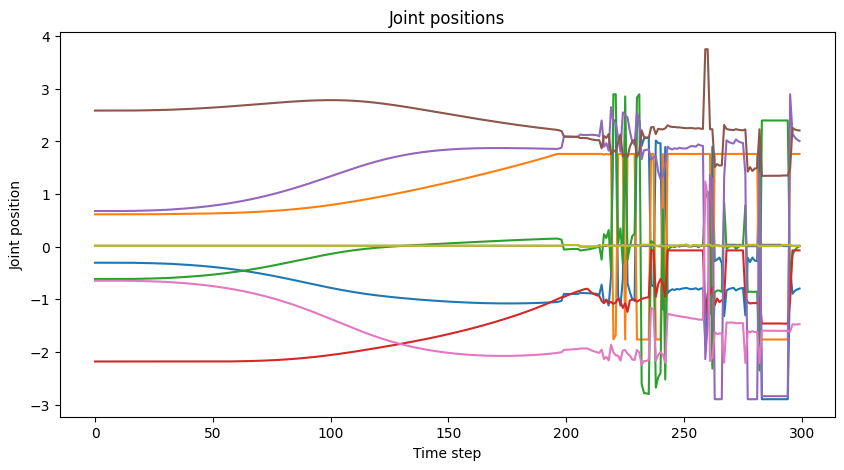

In [272]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [273]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step() 

[Genesis] [20:53:47] [INFO] Running at 2.76 FPS.
[Genesis] [20:53:47] [INFO] Running at 2.86 FPS.
[Genesis] [20:53:47] [INFO] Running at 2.98 FPS.
[Genesis] [20:53:47] [INFO] Running at 3.10 FPS.
[Genesis] [20:53:47] [INFO] Running at 3.24 FPS.
[Genesis] [20:53:47] [INFO] Running at 3.39 FPS.
[Genesis] [20:53:47] [INFO] Running at 3.54 FPS.
[Genesis] [20:53:47] [INFO] Running at 3.69 FPS.
[Genesis] [20:53:47] [INFO] Running at 3.85 FPS.
[Genesis] [20:53:47] [INFO] Running at 4.00 FPS.
[Genesis] [20:53:48] [INFO] Running at 4.13 FPS.
[Genesis] [20:53:48] [INFO] Running at 4.27 FPS.
[Genesis] [20:53:48] [INFO] Running at 4.42 FPS.
[Genesis] [20:53:48] [INFO] Running at 4.57 FPS.
[Genesis] [20:53:48] [INFO] Running at 4.74 FPS.
[Genesis] [20:53:48] [INFO] Running at 4.88 FPS.
[Genesis] [20:53:48] [INFO] Running at 5.06 FPS.
[Genesis] [20:53:48] [INFO] Running at 5.26 FPS.
[Genesis] [20:53:48] [INFO] Running at 5.47 FPS.
[Genesis] [20:53:48] [INFO] Running at 5.65 FPS.
[Genesis] [20:53:48]

### Uprighting the cylinder

In [214]:
# franka is in ready position
scene.reset()
cylinder.set_pos([-0.35, -0.25, 0.03])
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [20:40:21] [INFO] Resetting Scene <9a3ef60>.
[Genesis] [20:40:21] [INFO] Running at 0.96 FPS.


In [215]:
# move to pre-grasp pose for cylinder
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cylinder = obj_grasp(cylinder, 'min_distance')
print(pq_grasp_cylinder)
print(pt.transform_from_pq(pq_grasp_cylinder))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cylinder[:3] , # position of the end effector
    quat = pq_grasp_cylinder[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 9.99963818e-01 -4.75064212e-20 -8.50667429e-03 -2.93870985e-01]
 [-4.93311856e-20 -1.00000000e+00 -2.14299905e-19 -2.50000000e-01]
 [-8.50667429e-03  2.14711796e-19 -9.99963818e-01  1.38863288e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-2.93870985e-01 -2.50000000e-01  1.38863288e-01  1.07253896e-19
  9.99990954e-01 -2.42096207e-20 -4.25337562e-03]
[[ 9.99963818e-01 -4.75064212e-20 -8.50667429e-03 -2.93870985e-01]
 [-4.93311856e-20 -1.00000000e+00 -2.14299905e-19 -2.50000000e-01]
 [-8.50667429e-03  2.14711796e-19 -9.99963818e-01  1.38863288e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[Genesis] [20:40:27] [INFO] Running at 0.77 FPS.
[Genesis] [20:40:27] [INFO] Running at 0.80 FPS.
[Genesis] [20:40:28] [INFO] Running at 0.84 FPS.
[Genesis] [20:40:28] [INFO] Running at 0.88 FPS.
[Genesis] [20:40:28] [INFO] Running at 0.92 FPS.
[Genesis] [20:40:28] [INFO] Running at 0.97 FPS.
[Genesis] [20:40:28] [INFO] Running at 1.0

In [216]:
# closing fingers to grasp the cylinder
franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

[Genesis] [20:40:34] [INFO] Running at 7.07 FPS.
[Genesis] [20:40:34] [INFO] Running at 7.20 FPS.
[Genesis] [20:40:34] [INFO] Running at 7.37 FPS.
[Genesis] [20:40:35] [INFO] Running at 7.60 FPS.
[Genesis] [20:40:35] [INFO] Running at 7.84 FPS.
[Genesis] [20:40:35] [INFO] Running at 8.07 FPS.
[Genesis] [20:40:35] [INFO] Running at 8.25 FPS.
[Genesis] [20:40:35] [INFO] Running at 8.47 FPS.
[Genesis] [20:40:35] [INFO] Running at 8.59 FPS.
[Genesis] [20:40:35] [INFO] Running at 8.68 FPS.
[Genesis] [20:40:35] [INFO] Running at 8.90 FPS.
[Genesis] [20:40:35] [INFO] Running at 9.15 FPS.
[Genesis] [20:40:35] [INFO] Running at 9.39 FPS.
[Genesis] [20:40:35] [INFO] Running at 9.65 FPS.
[Genesis] [20:40:35] [INFO] Running at 9.83 FPS.
[Genesis] [20:40:35] [INFO] Running at 10.00 FPS.
[Genesis] [20:40:35] [INFO] Running at 10.28 FPS.
[Genesis] [20:40:35] [INFO] Running at 10.54 FPS.
[Genesis] [20:40:35] [INFO] Running at 10.78 FPS.
[Genesis] [20:40:36] [INFO] Running at 11.03 FPS.
[Genesis] [20:4

In [217]:
# franka sclerp to upright the cylinder
franka_pqs = franka_sclerp(cylinder, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

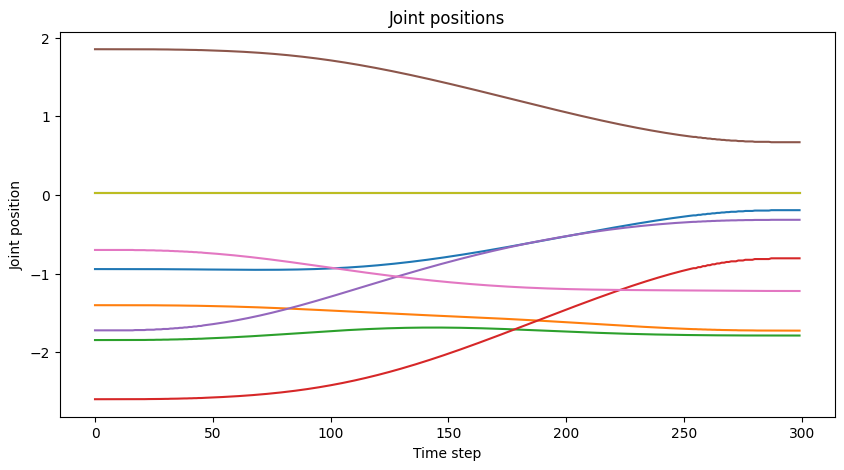

In [218]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [219]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   
    

[Genesis] [20:40:43] [INFO] Running at 2.92 FPS.
[Genesis] [20:40:43] [INFO] Running at 3.04 FPS.
[Genesis] [20:40:43] [INFO] Running at 3.15 FPS.
[Genesis] [20:40:43] [INFO] Running at 3.27 FPS.
[Genesis] [20:40:43] [INFO] Running at 3.41 FPS.
[Genesis] [20:40:43] [INFO] Running at 3.54 FPS.
[Genesis] [20:40:43] [INFO] Running at 3.67 FPS.
[Genesis] [20:40:44] [INFO] Running at 3.79 FPS.
[Genesis] [20:40:44] [INFO] Running at 3.94 FPS.
[Genesis] [20:40:44] [INFO] Running at 4.07 FPS.
[Genesis] [20:40:44] [INFO] Running at 4.20 FPS.
[Genesis] [20:40:44] [INFO] Running at 4.36 FPS.
[Genesis] [20:40:44] [INFO] Running at 4.53 FPS.
[Genesis] [20:40:44] [INFO] Running at 4.71 FPS.
[Genesis] [20:40:44] [INFO] Running at 4.88 FPS.
[Genesis] [20:40:44] [INFO] Running at 5.05 FPS.
[Genesis] [20:40:44] [INFO] Running at 5.22 FPS.
[Genesis] [20:40:44] [INFO] Running at 5.32 FPS.
[Genesis] [20:40:44] [INFO] Running at 5.43 FPS.
[Genesis] [20:40:45] [INFO] Running at 5.63 FPS.
[Genesis] [20:40:45]

In [101]:
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for _ in range(150):
    
    scene.step()

[Genesis] [19:16:45] [INFO] Running at 4.61 FPS.
[Genesis] [19:16:45] [INFO] Running at 4.74 FPS.
[Genesis] [19:16:45] [INFO] Running at 4.91 FPS.
[Genesis] [19:16:45] [INFO] Running at 5.12 FPS.
[Genesis] [19:16:45] [INFO] Running at 5.35 FPS.
[Genesis] [19:16:45] [INFO] Running at 5.56 FPS.
[Genesis] [19:16:45] [INFO] Running at 5.81 FPS.
[Genesis] [19:16:45] [INFO] Running at 6.07 FPS.
[Genesis] [19:16:45] [INFO] Running at 6.33 FPS.
[Genesis] [19:16:45] [INFO] Running at 6.61 FPS.
[Genesis] [19:16:45] [INFO] Running at 6.89 FPS.
[Genesis] [19:16:45] [INFO] Running at 7.19 FPS.
[Genesis] [19:16:45] [INFO] Running at 7.41 FPS.
[Genesis] [19:16:45] [INFO] Running at 7.62 FPS.
[Genesis] [19:16:45] [INFO] Running at 7.84 FPS.
[Genesis] [19:16:46] [INFO] Running at 8.16 FPS.
[Genesis] [19:16:46] [INFO] Running at 8.48 FPS.
[Genesis] [19:16:46] [INFO] Running at 8.78 FPS.
[Genesis] [19:16:46] [INFO] Running at 9.07 FPS.
[Genesis] [19:16:46] [INFO] Running at 9.44 FPS.
[Genesis] [19:16:46]

### Uprighting the cube

In [220]:
# franka is in ready position
scene.reset()
cube.set_pos([0.45,0.1,0.04])
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [20:41:24] [INFO] Resetting Scene <9a3ef60>.
[Genesis] [20:41:24] [INFO] Running at 1.13 FPS.


In [221]:
# move to pre-grasp pose for cube
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cube = obj_grasp(cube, 'min_distance')
print(pq_grasp_cube)
print(pt.transform_from_pq(pq_grasp_cube))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cube[:3] , # position of the end effector
    quat = pq_grasp_cube[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 0.          1.          0.          0.44999999]
 [ 1.          0.          0.          0.13      ]
 [ 0.          0.         -1.          0.18259395]
 [ 0.          0.          0.          1.        ]]
[0.44999999 0.13       0.18259395 0.         0.70710678 0.70710678
 0.        ]
[[-2.22044605e-16  1.00000000e+00  0.00000000e+00  4.49999988e-01]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00  1.30000001e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  1.82593949e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[Genesis] [20:41:26] [INFO] Running at 1.03 FPS.
[Genesis] [20:41:26] [INFO] Running at 1.08 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.13 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.18 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.24 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.30 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.36 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.43 FPS.
[Genesis] [20:41:27] [INFO] Running at 1.50

In [222]:
# closing fingers to grasp the cube
franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

[Genesis] [20:41:34] [INFO] Running at 5.93 FPS.
[Genesis] [20:41:34] [INFO] Running at 6.02 FPS.
[Genesis] [20:41:34] [INFO] Running at 6.22 FPS.
[Genesis] [20:41:34] [INFO] Running at 6.46 FPS.
[Genesis] [20:41:34] [INFO] Running at 6.62 FPS.
[Genesis] [20:41:34] [INFO] Running at 6.83 FPS.
[Genesis] [20:41:34] [INFO] Running at 7.04 FPS.
[Genesis] [20:41:34] [INFO] Running at 7.07 FPS.
[Genesis] [20:41:34] [INFO] Running at 7.26 FPS.
[Genesis] [20:41:34] [INFO] Running at 7.49 FPS.
[Genesis] [20:41:34] [INFO] Running at 7.67 FPS.
[Genesis] [20:41:34] [INFO] Running at 7.91 FPS.
[Genesis] [20:41:34] [INFO] Running at 8.17 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.34 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.43 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.36 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.39 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.48 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.41 FPS.
[Genesis] [20:41:35] [INFO] Running at 8.61 FPS.
[Genesis] [20:41:35]

In [223]:
# franka sclerp to upright the cube
franka_pqs = franka_sclerp(cube, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

In [ ]:
# damping = 1e-6
# diag = damping * np.eye(6)
# for i in range(franka_pqs.shape[0]):
#     # Position error.
#     error_pos = franka_pqs[i][:3] - end_effector.get_pos().cpu().numpy()

#     # Orientation error.
#     ee_quat = end_effector.get_quat().cpu().numpy()
#     error_quat = gs.transform_quat_by_quat(gs.inv_quat(ee_quat), franka_pqs[i][3:7])
#     error_rotvec = gs.quat_to_rotvec(error_quat)

#     error = np.concatenate([error_pos, error_rotvec])

#     # jacobian
#     jac = franka.get_jacobian(link=end_effector).cpu().numpy()
#     dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)
#     q = franka.get_qpos().cpu().numpy() + dq

#     # control
#     franka.control_dofs_position(q)
#     scene.step()

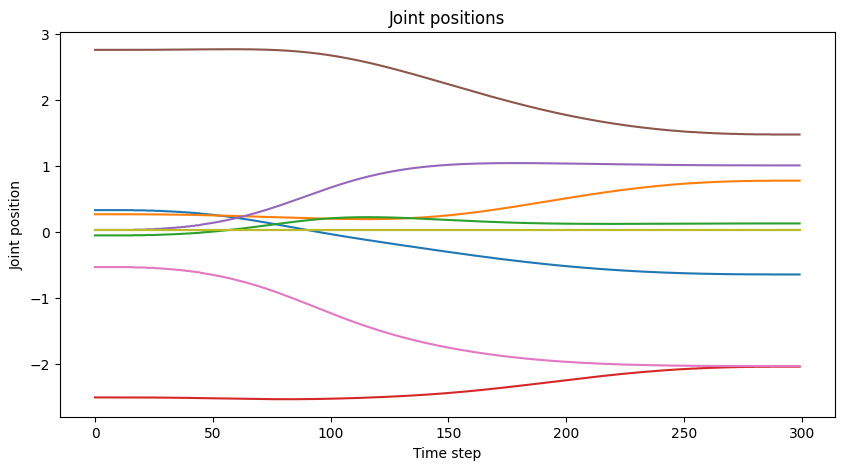

In [224]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [225]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   

[Genesis] [20:41:50] [INFO] Running at 1.49 FPS.
[Genesis] [20:41:50] [INFO] Running at 1.55 FPS.
[Genesis] [20:41:50] [INFO] Running at 1.63 FPS.
[Genesis] [20:41:50] [INFO] Running at 1.70 FPS.
[Genesis] [20:41:50] [INFO] Running at 1.77 FPS.
[Genesis] [20:41:50] [INFO] Running at 1.85 FPS.
[Genesis] [20:41:50] [INFO] Running at 1.93 FPS.
[Genesis] [20:41:50] [INFO] Running at 2.02 FPS.
[Genesis] [20:41:50] [INFO] Running at 2.12 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.21 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.31 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.40 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.49 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.58 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.68 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.80 FPS.
[Genesis] [20:41:51] [INFO] Running at 2.92 FPS.
[Genesis] [20:41:52] [INFO] Running at 2.85 FPS.
[Genesis] [20:41:52] [INFO] Running at 2.97 FPS.
[Genesis] [20:41:52] [INFO] Running at 3.06 FPS.
[Genesis] [20:41:52]

### Objects Sclerp

In [171]:
# calling functions for cube_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cube)
cube_initial_dq, Cube_goal_dq = obj_dq(cube, 'min_distance')
dq_traj, obj_qpos = obj_sclerp(cube, cube_initial_dq, Cube_goal_dq, 'linear', 100)
dq_traj.shape

[Genesis] [19:53:59] [INFO] Resetting Scene <9a3ef60>.


(100, 8)

In [172]:
# cube sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cube.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [19:54:01] [INFO] Resetting Scene <9a3ef60>.


[Genesis] [19:54:01] [INFO] Running at 0.03 FPS.
[Genesis] [19:54:01] [INFO] Running at 0.03 FPS.
[Genesis] [19:54:01] [INFO] Running at 0.03 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.03 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.03 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.03 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.04 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.04 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.04 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.04 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.04 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.05 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.05 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.05 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.05 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.06 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.06 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.06 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.07 FPS.
[Genesis] [19:54:02] [INFO] Running at 0.07 FPS.
[Genesis] [19:54:02]

In [173]:
# calling functions for cylinder_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cylinder)
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder, 'min_distance')
dq_traj, obj_qpos = obj_sclerp(cylinder, cyl_initial_dq, cyl_goal_dq, 'linear', 100)
dq_traj.shape

[Genesis] [19:54:08] [INFO] Resetting Scene <9a3ef60>.


(100, 8)

In [174]:
# cylinder sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cylinder.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [19:54:10] [INFO] Resetting Scene <9a3ef60>.


[Genesis] [19:54:10] [INFO] Running at 1.95 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.04 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.14 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.23 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.32 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.43 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.54 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.66 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.79 FPS.
[Genesis] [19:54:10] [INFO] Running at 2.92 FPS.
[Genesis] [19:54:10] [INFO] Running at 3.05 FPS.
[Genesis] [19:54:10] [INFO] Running at 3.19 FPS.
[Genesis] [19:54:11] [INFO] Running at 3.32 FPS.
[Genesis] [19:54:11] [INFO] Running at 3.48 FPS.
[Genesis] [19:54:11] [INFO] Running at 3.64 FPS.
[Genesis] [19:54:11] [INFO] Running at 3.81 FPS.
[Genesis] [19:54:11] [INFO] Running at 3.99 FPS.
[Genesis] [19:54:11] [INFO] Running at 4.16 FPS.
[Genesis] [19:54:11] [INFO] Running at 4.31 FPS.
[Genesis] [19:54:11] [INFO] Running at 4.44 FPS.
[Genesis] [19:54:11]

In [267]:
# calling functions for bottle_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(bottle)
bottle_initial_dq, bottle_goal_dq = obj_dq(bottle, 'min_distance')

bottle_traj, bottle_qpos = obj_sclerp(bottle, bottle_initial_dq, bottle_goal_dq, 'linear', 100)

[Genesis] [20:53:07] [INFO] Resetting Scene <9a3ef60>.


In [266]:
# bottle sclerp motion
scene.reset()
for i in range (bottle_qpos.shape[0]):
    franka.set_qpos(qr)
    bottle.set_qpos(np.append(bottle_qpos[i], [0,0]))
    scene.step()

[Genesis] [20:52:54] [INFO] Resetting Scene <9a3ef60>.
[Genesis] [20:52:54] [INFO] Running at 5.31 FPS.
[Genesis] [20:52:54] [INFO] Running at 5.53 FPS.
[Genesis] [20:52:55] [INFO] Running at 5.72 FPS.
[Genesis] [20:52:55] [INFO] Running at 5.86 FPS.
[Genesis] [20:52:55] [INFO] Running at 6.08 FPS.
[Genesis] [20:52:55] [INFO] Running at 6.34 FPS.
[Genesis] [20:52:55] [INFO] Running at 6.55 FPS.
[Genesis] [20:52:55] [INFO] Running at 6.71 FPS.
[Genesis] [20:52:55] [INFO] Running at 6.88 FPS.
[Genesis] [20:52:55] [INFO] Running at 7.04 FPS.
[Genesis] [20:52:55] [INFO] Running at 7.23 FPS.
[Genesis] [20:52:55] [INFO] Running at 7.48 FPS.
[Genesis] [20:52:55] [INFO] Running at 7.73 FPS.
[Genesis] [20:52:55] [INFO] Running at 8.04 FPS.
[Genesis] [20:52:55] [INFO] Running at 8.32 FPS.
[Genesis] [20:52:55] [INFO] Running at 8.56 FPS.
[Genesis] [20:52:55] [INFO] Running at 8.82 FPS.
[Genesis] [20:52:55] [INFO] Running at 8.93 FPS.
[Genesis] [20:52:56] [INFO] Running at 9.05 FPS.
[Genesis] [20: